# Homework 6
Due: Thurs 4/25/24 at 6 pm CT \
Submit as .ipynb file

# Scoring
- (1) = 25 points
    - (a)-(e): 5 points each
        - +2 points for attempting
        - +3 points for satisfactory answer
- (2) = 25 points
    - (a)-(c): 5 points each
        - +2 points for attempting
        - +3 points for satisfactory answer
    - (d): 10 points
        - +5 points for attempting
        - +5 points for success
- (3) = 50 points
    - (a)-(d), (g): 4 points each
        - +2 points for attempting
        - +2 points for success
    - (e)-(f): 15 points each
        - +5 points for attempting
        - +10 points for success

In [69]:
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction import xrd
from pymatgen.core.composition import Composition
from matminer.featurizers.structure.misc import XRDPowderPattern
from matminer.datasets import load_dataset
from matminer.featurizers.composition.element import ElementFraction, TMetalFraction

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy
from ast import literal_eval

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
plt.style.use('../../modules/files/plot_style.mplstyle')

# (1) Read [this paper](https://www.nature.com/articles/s41524-020-00362-y) and answer the following questions
### (1a) What was the source of the data used for training and evaluating machine learning models in this work?
### (1b) What is the difference between a compositional and structural representation?
### (1c) Explain how accuracy, F1 score, and false positive rate give distinct insights into the performance of a classification model
### (1d) Five compositional representations from the literature are compared in this work ("Meredig [20], Magpie [21], AutoMat [22], ElemNet [23], and Roost [24]"), pick one and briefly explain how it works
### (1e) The code used to perform the analysis reported in this paper is available. Investigate this GitHub repository and state which deep learning framework was used to train the ElemNet model.

#### STUDENTS ANSWER HERE
(1a) The data used for training and evaluating machine learning models in this work was obtained from the Materials Project database of Density Functional Theory (DFT) calculations for 85,014 unique chemical compositions.

(1b) Compositional representation uses the chemical formula as input to predict material properties without considering the structure. Examples of compositional representations include Meredig, Magpie, AutoMat, ElemNet, and Roost, which utilize different approaches to represent materials based on their composition. Structural Representation evaluates material properties based on composition and crystal structure, providing a more comprehensive analysis. Crystal graph convolutional neural networks (CGCNN) are an example of a structural model that uses message passing over atoms and bonds in a crystal to predict properties.

(1c) Accuracy provides an overall measure of correct predictions in a model, indicating the proportion of correctly classified instances. F1 Score considers both a model's precision and recall, providing a balance between them. It is particularly useful when dealing with imbalanced classes. False Positive Rate reveals the rate of incorrect positive predictions made by the model, which is crucial in scenarios where misclassifying negatives as positives can have significant consequences.

(1d) ElemNet is a deep learning model that automatically captures physical and chemical interactions between elements using artificial intelligence. The model bypasses manual feature engineering, achieving better results with only a few thousand training samples. By analyzing the activations of different materials in various layers, ElemNet demonstrates its ability to learn useful representations for accurate predictions. The model's high accuracy and speed enable fast screening of new material candidates in vast combinatorial spaces, aiding in the discovery of potentially undiscovered compounds.

(1e) Keras deep learning framework was used to train the ELemNet model.

# (2) Consider the following computational graph
![](../../modules/files/graph.png)

## Here is some starter code to get you going


In [70]:
def f1(a, b):
    ### fill in
    return c

def f2(c, d):
    ### fill in
    return e 

def f3(e):
    ### fill in
    return z

def forward(a, b, d):
    c = f1(a, b)
    e = f2(c, d)
    z = f3(e)
    return z 

## (2a) Complete the above functions considering: f1 is an addition gate, f2 is a multiplication gate, and f3 is a quadratic gate
**Guidelines**:
- your functions should work if a, b, d are scalars or 1d numpy arrays
- print the result of a full forward pass through this computational graph for two cases:
    - case 1: a = 2, b = 4, d = 6
    - case 2: a = [-2, 2, -2, 2], b = [4, 4, 4, 4], d = [0, 0, 3, 6]

**Hint**:
- the last element of "case 2" looks just like "case 1"
- `numpy` arrays handle operations more easily than lists

In [71]:
######## STUDENTS ANSWER HERE
def f1(a, b):
    c = a + b  
    return c

def f2(c, d):
    e = np.multiply(c, d) 
    return e 

def f3(e):
    z = np.square(e) 
    return z

def forward(a, b, d):
    c = f1(a, b)
    e = f2(c, d)
    z = f3(e)
    return z

# Test cases
a1, b1, d1 = 2, 4, 6
a2, b2, d2 = np.array([-2, 2, -2, 2]), np.array([4, 4, 4, 4]), np.array([0, 0, 3, 6])

# Forward pass for case 1
result_case1 = forward(a1, b1, d1)
print("Result for case 1:", result_case1)

# Forward pass for case 2
result_case2 = forward(a2, b2, d2)
print("Result for case 2:", result_case2)

Result for case 1: 1296
Result for case 2: [   0    0   36 1296]


## (2b) You want the effect of `a` on `z`, write a separate function for each local gradient that must be computed, then combine them together into a function called backward that computes `dz/da`
**Guidelines**:
- print dz/da for Case 2 from (2a)

**Hints**:
- you should write 4 functions
    - 3 local gradients
    - 1 function that chains them together (`backward`)


In [72]:
######## STUDENTS ANSWER 
def df1_da():
    return 1

def df2_dc(d):
    return d

def df3_de(e):
    return 2 * e

def backward(a, b, d):
    a, b, d = np.array(a), np.array(b), np.array(d)
    c = f1(a, b)
    e = f2(c, d)
    
    dc_da = df1_da()
    de_dc = df2_dc(d)
    dz_de = df3_de(e)
    
    dz_da = dc_da * de_dc * dz_de
    
    return dz_da
test_case_1 = (2, 4, 6)
test_case_2 = ([-2, 2, -2, 2], [4, 4, 4, 4], [0, 0, 3, 6])

dz_da_case_2 = backward(*test_case_2)

print("dz/da for case 2:", dz_da_case_2)

dz/da for case 2: [  0   0  36 432]


## (2c) let's say you want to update `a` to minimize `z` using a gradient descent-like procedure. write a function to "update" `a` using explicit updates by completing the following function
**Guidelines**:
- for `a, b, d = 2, 4, 6` and learning rate of 10**-4, print the next `a` value
- does `a` increase or decrease? why does this make sense?

In [73]:
def update_a(prev_a, dz_da, learning_rate):
    ### fill in
    return new_a

In [74]:
########## STUDENTS ANSWER HERE
def update_a(prev_a, dz_da, learning_rate):
    new_a = prev_a - learning_rate * dz_da
    return new_a

a = 2
b = 4
d = 6
learning_rate = 10**-4

dz_da = 2 * a * d
new_a = update_a(a, dz_da, learning_rate)

print("Next value of a:", new_a)

Next value of a: 1.9976


## (2d) Perform 1000 sequential parameter updates for `a` for three cases
**Guidelines**:
- case 3: a, b, d = [0.5, 0, 0.5]; learning rate = 1e-3
- case 4: a, b, d = [0.5, 0, 0.5]; learning rate = 1e-2
- case 5: a, b, d = [0, 0, 0.5]; learning rate = 1e-2
- you should make 3 subplots with case 3 on the left, case 4 in the middle, and case 5 on the right
- plot z as a function of parameter update iterations
- the y axis should range from 0 to the value of z given the case 3 inputs
- answer the following questions:
    - which case is most successful? why?
    - which case is least successful? why?
    - explain the effect of learning rate on the difference between case 3 and case 4
    - explain what is happening with case 5

C:\Users\emman\anaconda3\envs\cems5802_24.0\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


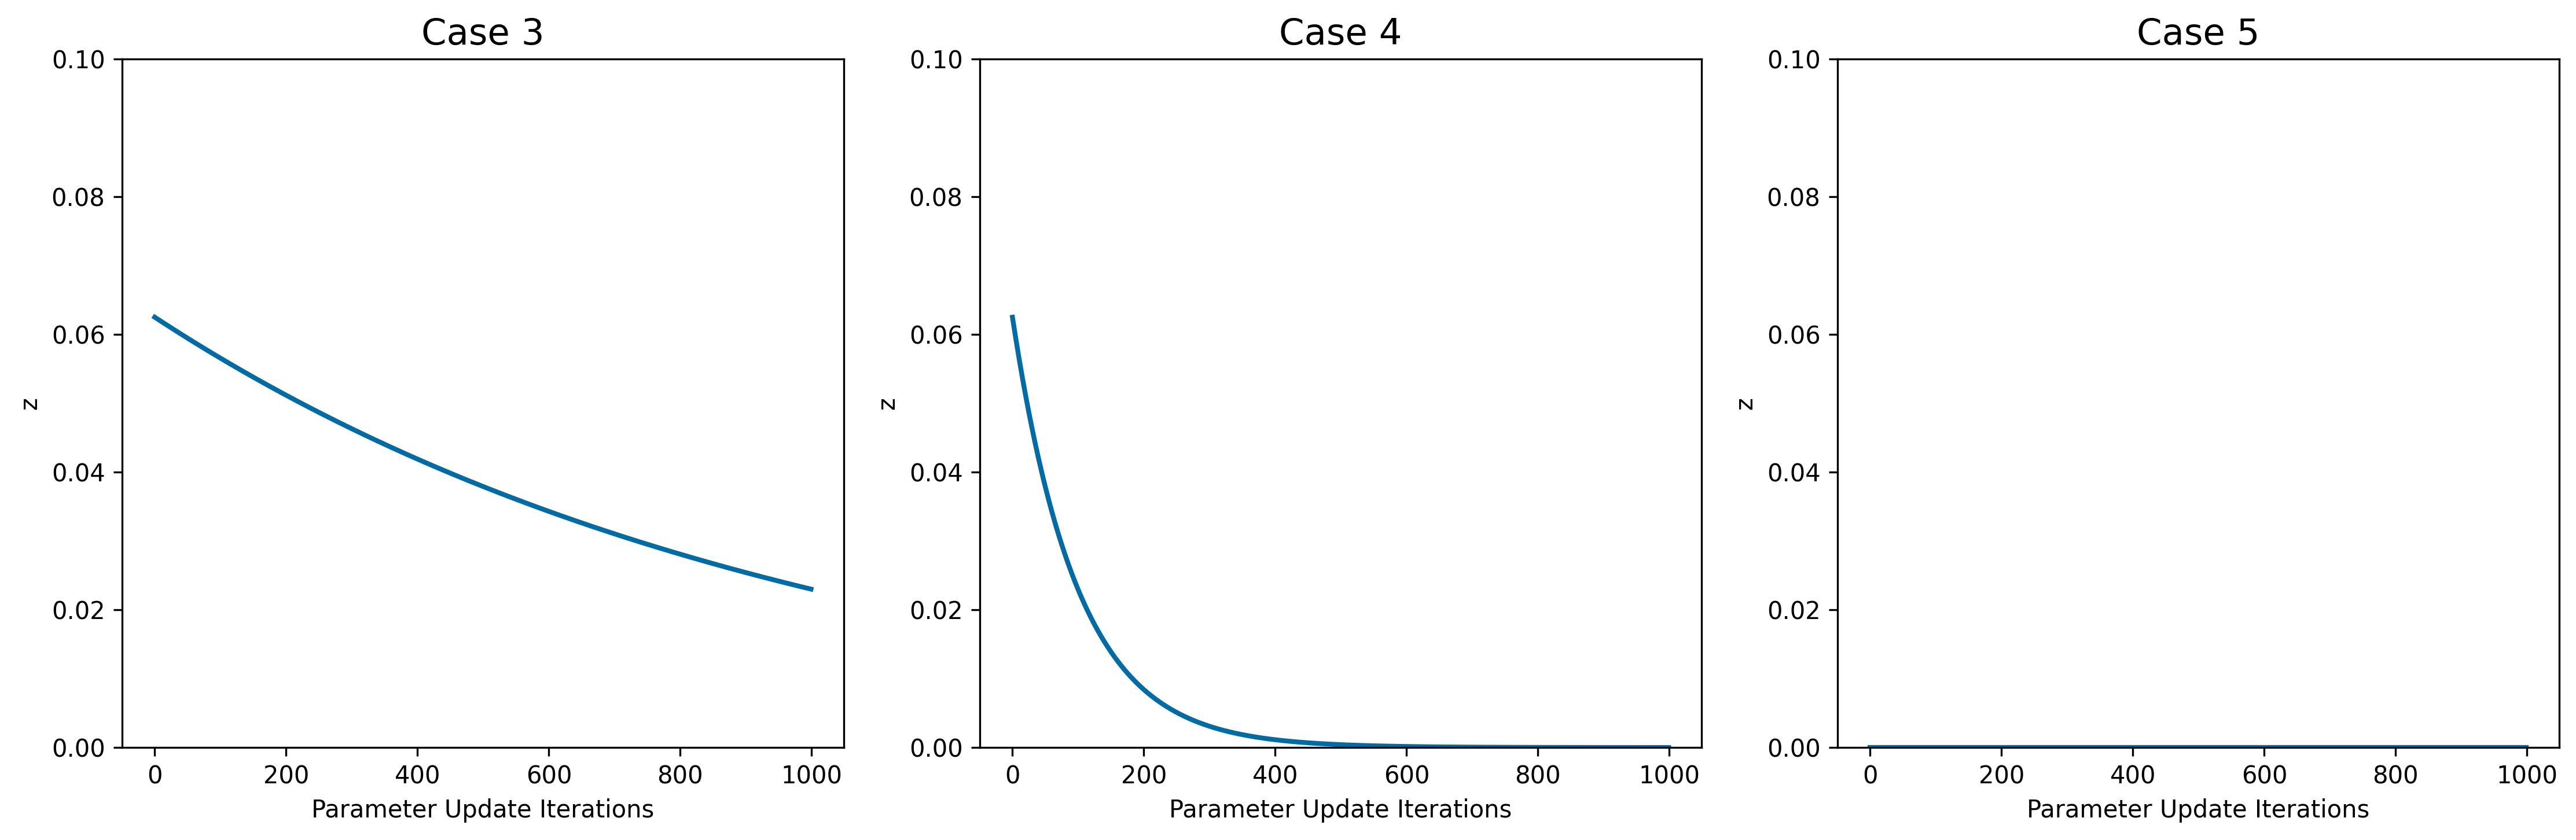

In [75]:
###### STUDENTS ANSWER HERE
cases = [
    {"a": 0.5, "b": 0, "d": 0.5, "learning_rate": 1e-3},
    {"a": 0.5, "b": 0, "d": 0.5, "learning_rate": 1e-2},
    {"a": 0, "b": 0, "d": 0.5, "learning_rate": 1e-2}
]

z_values = [[] for _ in range(len(cases))]

for case_idx, case in enumerate(cases):
    a = case["a"]
    b = case["b"]
    d = case["d"]
    learning_rate = case["learning_rate"]
    
    for _ in range(1000):
        # Forward pass
        c = f1(a, b)
        e = f2(c, d)
        z = f3(e)
        z_values[case_idx].append(z)

        dz_da = 2 * e * d

        a = update_a(a, dz_da, learning_rate)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for case_idx, ax in enumerate(axs):
    ax.plot(range(1000), z_values[case_idx])
    ax.set_title(f"Case {case_idx + 3}")
    ax.set_xlabel("Parameter Update Iterations")
    ax.set_ylabel("z")
    ax.set_ylim(0, 0.1) 

plt.tight_layout()
plt.show()

### STUDENTS ANSWER HERE
1. Which case is most successful? Why?

   Case 4 (middle subplot) is the most successful because it converges to a minimum value of z relatively quickly and remains stable. This success is likely due to the low learning rate, which allows for smaller updates and better convergence without overshooting the minimum.

2. Which case is least successful? Why?

   Case 5 (right subplot) is the least successful as it does not update or converge to a stable minimum value for z. This lack of success is because the initial value of a is 0, and one of the derivatives is also 0, causing the algorithm to get stuck at a local minimum (possibly a saddle point) rather than converging to the global minimum.

3. Explain the effect of learning rate on the difference between case 3 and case 4.

   Case 3 has a lower learning rate (1e-3) compared to Case 4 (1e-2). The lower learning rate in Case 3 results in smaller updates to a, allowing for more precise adjustments towards the minimum value of z. In contrast, the higher learning rate in Case 4 causes larger updates, which may lead to reaching the minimum quickly, making it converge.

4. Explain what is happening with case 5.

   In Case 5, where a is initialized to 0, and one of the derivatives like dz/da is also equal to 0, the graph does not update. This behavior occurs because starting from a=0, the gradient descent algorithm gets trapped in a local minimum (or a saddle point), preventing it from converging to the global minimum of z. Consequently, the values of z fluctuate and do not stabilize over the itertions.

# (3) Let's load a dataset of metal nitrides that have been calculated with DFT
## They provide the initial (pre-DFT) and final (post-DFT) structures and also the energy per atom

In [76]:
df = load_dataset('tholander_nitrides')
df.head()

,material_id,ht_id,initial_structure,final_structure,E_vasp_per_atom,chemical_system
0,TAATA_Zn-Hf-N_1,0019407b910a29730999dab65491b4e50624c219,"[[1.69598933 2.9375397 0.48822704] Hf, [ 3.39...","[[1.79022665 3.10076303 0.71219502] Hf, [ 3.58...",-6.057485,Hf-N-Zn
1,TAATA_Zn-Hf-N_2,00021364446a637881257fd9ee912a422a6b1753,"[[2.17019242 3.97852523 1.87048516] Hf, [1.168...","[[1.70256933 4.23798578 2.81479904] Hf, [1.662...",-7.972411,Hf-N-Zn
2,TAATA_Zn-Hf-N_3,00fa7d75b7b2e1442df0a68071210c8d64b93ebe,"[[3.95898537 1.31966179 4.82260055] Zn, [1.319...","[[4.37163375 1.45721125 4.6195805 ] Zn, [1.457...",-8.732759,Hf-N-Zn
3,TAATA_Zn-Hf-N_4,0039f3c461ce4a2cbf4c48b09bfc3c6b13a5c769,"[[5.04521665 0.28624542 3.54516154] Hf, [2.549...","[[0.00411385 0.4383154 3.97350105] Hf, [2.648...",-8.358905,Hf-N-Zn
4,TAATA_Zn-Hf-N_5,00af9b9350147b8c20498eb9cd65b63a3132c741,"[[-0.03311561 0. 2.93311306] Hf, [6....","[[0.82976591 0. 2.6247168 ] Hf, [8.501...",-7.235746,Hf-N-Zn


## add formulas

In [77]:
def get_formula(row):
    s = row['final_structure']
    formula = s.formula
    reduced_formula = Composition(formula).reduced_formula
    return reduced_formula

df['formula'] = df.apply(get_formula, axis=1)
df = df.rename(columns={'E_vasp_per_atom' : 'E'})

In [78]:
print('There are %i unique formulas in this dataset' % len(list(set(df.formula.values))))

There are 1694 unique formulas in this dataset


In [79]:
print('There is a wide range of how often any one formula appears:\n\n', df.formula.value_counts())

There is a wide range of how often any one formula appears:

 HfZnN3         385
TiZnN3         380
ZrZnN3         313
HfZnN2         257
TiZnN2         218
              ... 
Zr5Zn17N16       1
Zr7(Zn2N)3       1
Zr2(Zn2N5)3      1
Zr7(Zn2N3)2      1
Ti6Zn3N19        1
Name: formula, Length: 1694, dtype: int64


In [80]:
print('These formulas belong to %i chemical spaces' % len(list(set(df.chemical_system.values))))

These formulas belong to 15 chemical spaces


In [81]:
print('Chemical spaces are more evenly sampled:\n\n', df.chemical_system.value_counts())

Chemical spaces are more evenly sampled:

 Hf-N-Zn    4826
N-Ti-Zn    4312
N-Zn-Zr    3634
Ti-Zn         9
Hf-Zn         7
Zn-Zr         7
N-Zr          5
Hf-N          4
N-Ti          4
N-Zn          2
Hf            1
N             1
Zn            1
Zr            1
Ti            1
Name: chemical_system, dtype: int64


## We'll play around only with the ternary chemical spaces


In [82]:
df = df.get((df.chemical_system == 'Hf-N-Zn') | 
            (df.chemical_system == 'N-Ti-Zn') | 
            (df.chemical_system == 'N-Zn-Zr'))

## this dataset includes structures before DFT optimization (initial) and after (final). we'll only play with the final structures

In [83]:
if 'initial_structure' in list(df):
    del df['initial_structure']

## X-ray diffraction is a common tool for analyzing crystal structures. I went ahead and simulated XRD patterns for every final structure in this dataset. Let's add them to the dataframe

In [84]:
with open('../../modules/data/nitrides_xrd.json') as f:
    d = json.load(f)

In [85]:
patterns = {k : d[k]['final'] for k in d}

IDs = df.ht_id.values
df['pattern'] = [literal_eval(patterns[ID]) for ID in IDs]

In [86]:
[ID for ID in IDs if ID not in patterns]

[]

## we can think of an XRD pattern as a 1D representation of a crystal structure

In [87]:
def ax_pattern(pattern,
               twothetas='default',
                  show_y=True, show_x=True,
                  show_legend=False, show_title=False):
    """
    Args:
        pattern (1d array)
        twothetas (str) : only accepts 'default' now; specifies the angles where diffraction signal is known
        show_y (bool) : if False, don't show ylabel or yticks
        show_x (bool): if False, don't show xlabel or xticks
        show_legend (bool): if False, don't show legend
        show_title (bool): if False, don't show formul as title
        
    Returns:
        figure comparing XRD patterns of structures before and after DFT optimization
    
    """
    if twothetas == 'default':
        twothetas = np.linspace(0, 127, len(pattern))
    
    alpha = 0.8
    ax = plt.plot(twothetas, pattern, alpha=alpha)
    
    if show_x:
        ax = plt.xlabel(r'$2\theta$')
    else:
        ax = plt.gca().xaxis.set_ticklabels([])
    if show_y:
        ax = plt.ylabel('Norm. intensity')
    else:
        ax = plt.gca().yaxis.set_ticklabels([])
    if show_legend:
        ax = plt.legend()
    if show_title:
        ax = plt.title(Composition(initial_structure.formula).reduced_formula, fontsize=6)
    return ax

## Let's look at a random material and its XRD pattern

Full Formula (Hf1 Zn1 N2)
Reduced Formula: HfZnN2
abc   :   3.126831   3.126831   5.431700
angles:  90.000000  90.000000 120.000009
pbc   :       True       True       True
Sites (4)
  #  SP            a          b         c
---  ----  ---------  ---------  --------
  0  Hf    -0         -0         0
  1  Zn     0.666667   0.333333  0.5
  2  N      0.333333   0.666667  0.237176
  3  N      0.333333   0.666667  0.762824


C:\Users\emman\anaconda3\envs\cems5802_24.0\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


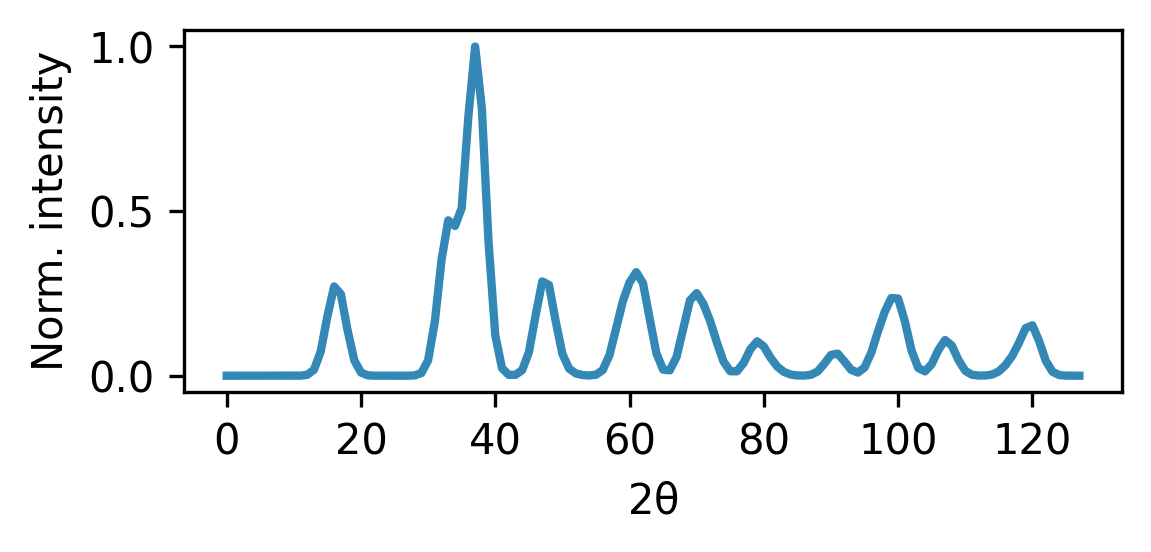

In [88]:
random_index = 1234

random_pattern = df.pattern.values[random_index]
random_structure = df.final_structure.values[random_index]

fig = plt.figure()
ax = plt.subplot(111)
ax = ax_pattern(random_pattern)
print(random_structure)

## a common challenge in materials science is to determine what phase or mixture of phases is present in a sample, given the XRD pattern we measure
- e.g., see [Probabilistic Deep Learning Approach to Automate the Interpretation of Multi-phase Diffraction Spectra](https://doi.org/10.1021/acs.chemmater.1c01071)

# let's see if deep learning can be used to figure out the chemical system given the pattern

## (3a) Set up a problem where we try to predict the chemical system from the XRD pattern(s)
**Guidelines**:
- Our target property has three values: ['Hf-N-Zn', 'N-Ti-Zn', 'N-Zn-Zr']
- Create a one-hot encoding to store these three classes as a vector of scalars, y
- Create a feature matrix using the XRD patterns, X
- Print the shapes of X and y
- Print (only) the unique values in your target array

**Hints**:
- your target vector should be 1 x N (where N is the number of samples). Each element of the vector should be a scalar. The vector should have three unique values in it
- Each feature for each sample is the intensity at some 2theta where we have data
- `np.concatenate` might be useful.. you might also need to `reshape`

In [89]:
######### STUDENTS ANSWER HERE
targets = df['chemical_system'].values 
unique_targets = np.unique(targets)
num_classes = len(unique_targets)

target_index = {target: i for i, target in enumerate(unique_targets)}
y = np.array([target_index[target] for target in targets])

X = np.array(df['pattern'].values.tolist())

print("Shape of X (feature matrix):", X.shape)
print("Shape of y (target vector):", y.shape)

print("Unique values in the target vector:", np.unique(y))

Shape of X (feature matrix): (12772, 128)
Shape of y (target vector): (12772,)
Unique values in the target vector: [0 1 2]


## (3b) Split your data into a training set and a test set on the basis of the chemical formula (composition)
**Guidelines**:
- create a DataFrame column `is_train` that indicates whether a given entry will be in the training set or the test set
- no chemical formula should appear in both the training set and the test set
- 80% of unique chemical formulas should appear in the training set, with the remainder appearing in the test set
- what fraction of your samples appear in the training set? (print this)
- what fraction of your chemical formulas appear in the training set? (print this)
- see the hints if you're not sure what to do

**Hints**:
- each data point (sample) you have corresponds with one material. a material can be defined by a chemical composition (e.g., ZnHfN2) that has crystallized into a given structure (a set of 3D atomic positions). 
- in this dataset, you should have hopefully noticed that for some chemical formulas, there are very many structures (e.g., ZnHfN3 has 385 structures in this dataset) 
- if our objective is to develop a model where we observe an XRD pattern for a structure having a chemical composition that we've never seen before, then it wouldn't make sense to train on (some) ZnHfN3 structures and test on (other) ZnHfN3 structures
- to make sure that our train/test split is reflective of this, you should split your data on the basis of chemical composition rather than on the basis of samples (row in your dataframe)

In [90]:
########### STUDENTS ANSWER HERE
df['is_train'] = False
unique_formulas = df['formula'].unique()
num_train_formulas = int(0.8 * len(unique_formulas))

np.random.shuffle(unique_formulas)

train_formulas = unique_formulas[:num_train_formulas]
df.loc[df['formula'].isin(train_formulas), 'is_train'] = True

total_samples = len(df)
train_samples = df['is_train'].sum()
train_fraction = train_samples / total_samples

total_formulas = len(unique_formulas)
train_formula_fraction = num_train_formulas / total_formulas

print("Fraction of samples in the training set:", train_fraction)
print("Fraction of chemical formulas in the training set:", train_formula_fraction)

Fraction of samples in the training set: 0.7913404321954275
Fraction of chemical formulas in the training set: 0.8


## (3c) Train a support vector classifier as a baseline
**Guidelines**:
- Use GridSearchCV to find a reasonable regularization parameter (lightly tune)
- Use accuracy as a scoring metric 
- Report the validation accuracy from 3-fold CV using the best regularization parameter

**Hints**:
- The best 3-fold CV validation accuracy I got was ~0.81

In [91]:
##### STUDENTS ANSWER HERE
X_train = X[df['is_train']]
y_train = y[df['is_train']]

param_grid = {'C': [0.1, 1, 10, 100]}
svc = SVC(kernel='linear')
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_svc = grid_search.best_estimator_

best_score = grid_search.best_score_
print("Best regularization parameter:", grid_search.best_params_)
print("Validation accuracy (3-fold CV):", best_score)

Best regularization parameter: {'C': 100}
Validation accuracy (3-fold CV): 0.7847036707232612


## Now, let's try deep learning. 
- we'll import the functions we wrote in `9_pytorch.ipynb` by providing a module file in this folder (`pytorch_helpers.py`)

In [92]:
from pytorch_helpers import JointDataSet, load_data, construct_model, score, train_one_batch, train_epochs, plot_accuracy_and_loss, prep_build_train_eval

## Let's see how things look using the default parameters
- note: we have three classes, so I need my model to output three values
- I'll set my baseline to be the best validation score I got with a support vector classifier


using 1010 (0.10) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
  (drop1): Dropout1d(p=0.1, inplace=False)
  (soft): Softmax(dim=1)
)

model has 34563 trainable parameters

best scores:

  training = 0.77
  validation = 0.64


C:\Users\emman\anaconda3\envs\cems5802_24.0\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


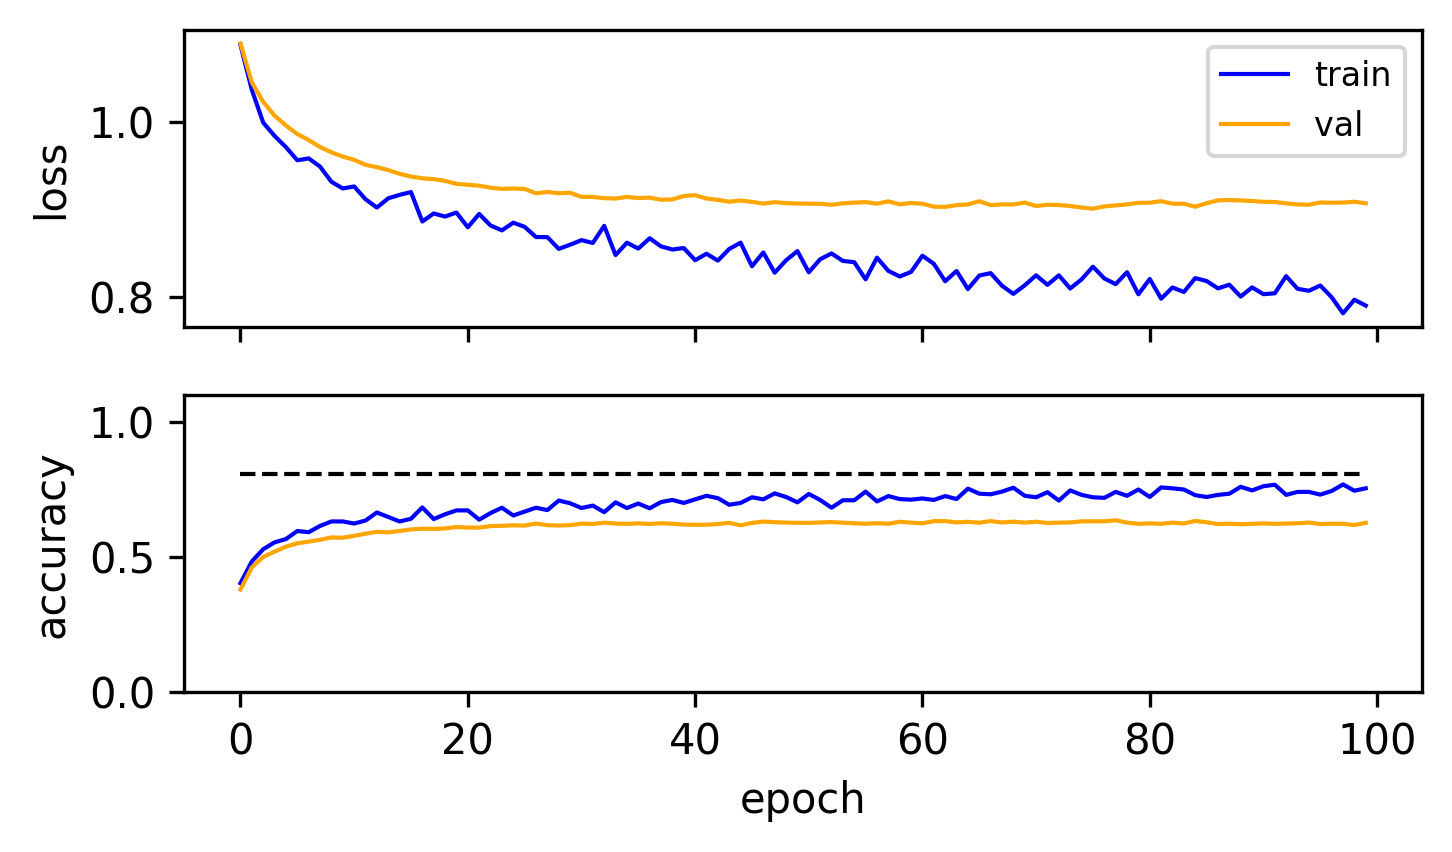

In [93]:
output_size = 3 # three target classes
baseline = 0.81 # my SVC score

results = prep_build_train_eval(X_train, y_train, output_size=output_size, baseline=baseline)

## (3d) Prove to yourself that this set of functions is working by overfitting to a very small number of data points
**Guidelines**:
- over-fitting means getting your accuracy to ~1.0 (it might not hit 1.0 but it should at least hit 0.97)

**Hints**:
- increasing `random_n` will decrease the number of points in your training set (this is what you want to do)
- you may have to tweak `num_epochs`, `hidden_layer_sizes`, `learning_rate`, `batch_size`, etc
- you may also think about what parameters you want to "turn off" if you are just going for the best possible training score


using 100 (0.01) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
  (drop1): Dropout1d(p=0.1, inplace=False)
  (soft): Softmax(dim=1)
)

model has 34563 trainable parameters

best scores:

  training = 0.98
  validation = 0.55


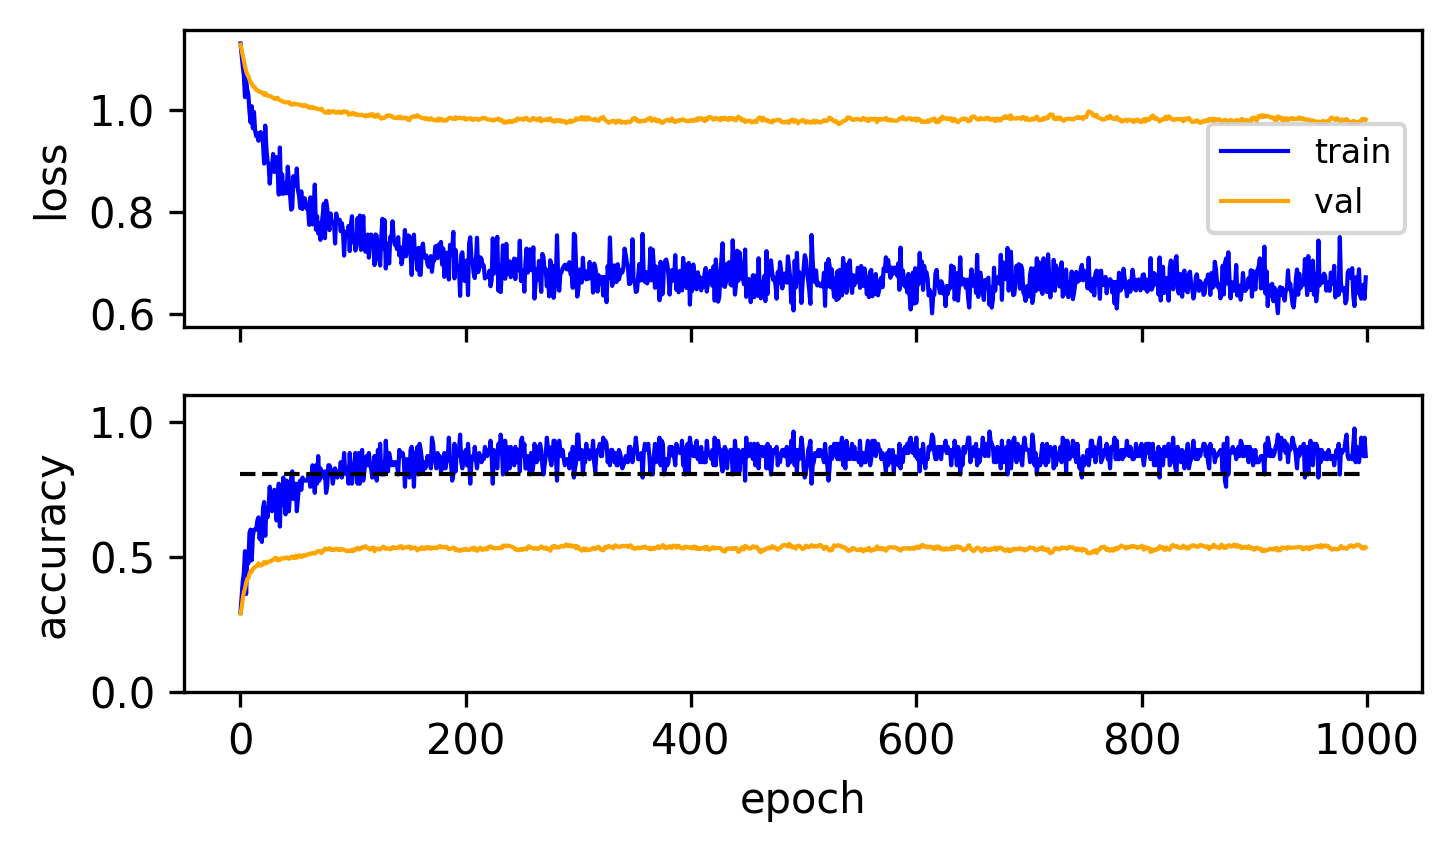

In [58]:
####### STUDENTS ANSWER HERE
random_n = 100
num_epochs = 1000

results = prep_build_train_eval(X_train, y_train, output_size=output_size, baseline=baseline, num_epochs=num_epochs, random_n=random_n)

## (3e) Explore the effect of various inputs on the training time
- **Guidelines**
  - `batch_size` and `hidden_layer_sizes` probably affect training time the most
  - fix `hidden_layer_sizes=[256]` and print the time required to train 10 epochs using five different batch sizes
  - fix `batch_size=128` and print the time required to train 10 epochs using five increasingly larger networks
  - use 20% of your data
  - briefly explain why these two inputs significantly influence the training time
- **Hints**:
  - the `time` module may be handy
  - note "larger" networks means more hidden layers and/or hidden layers with more neurons


using 10107 (1.00) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
  (drop1): Dropout1d(p=0.1, inplace=False)
  (soft): Softmax(dim=1)
)

model has 34563 trainable parameters

best scores:

  training = 0.68
  validation = 0.69
Batch Size: 16, Training Time: 208.0901322364807 seconds

using 10107 (1.00) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, 

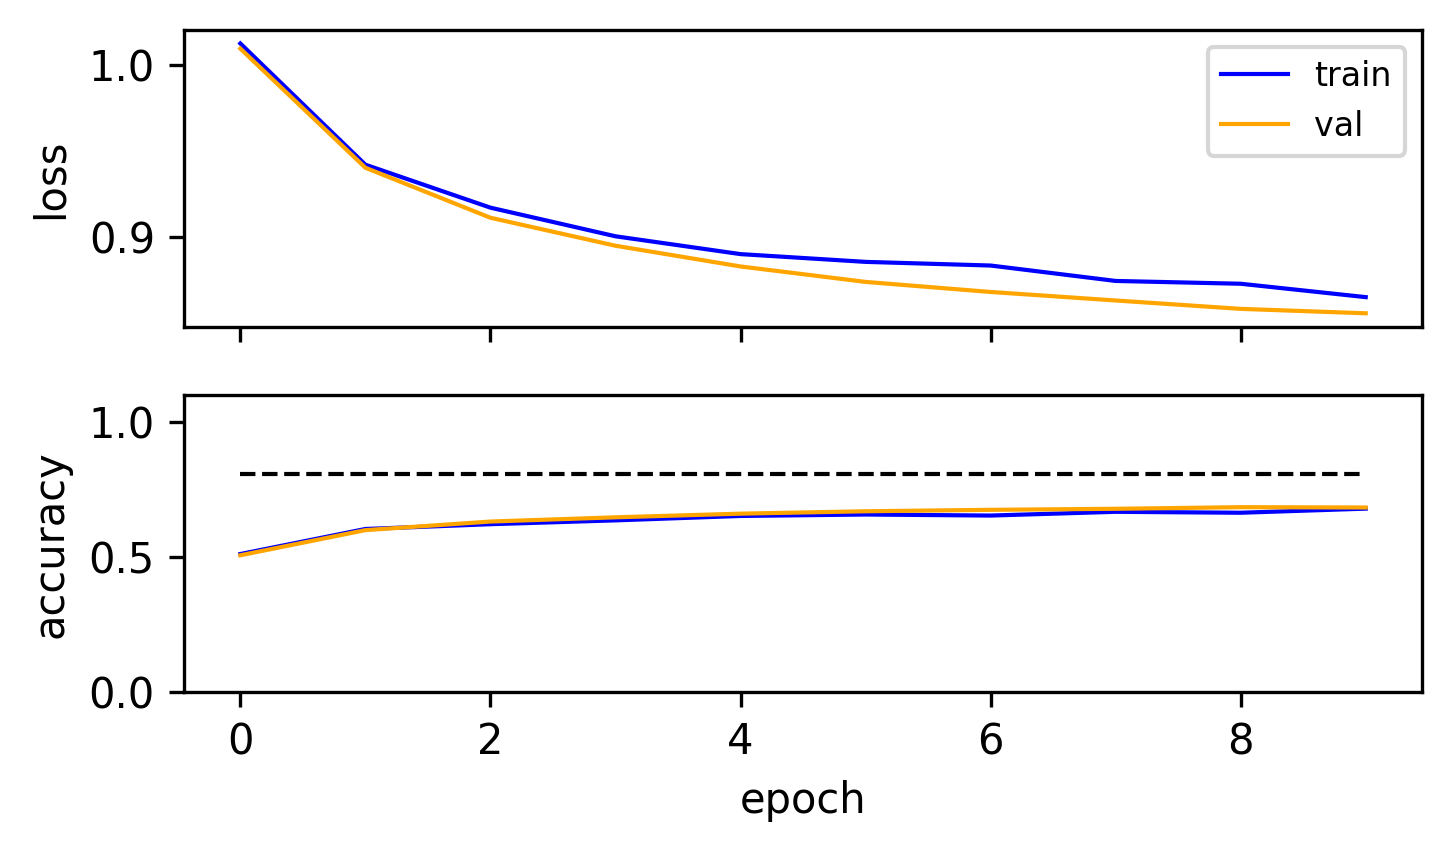

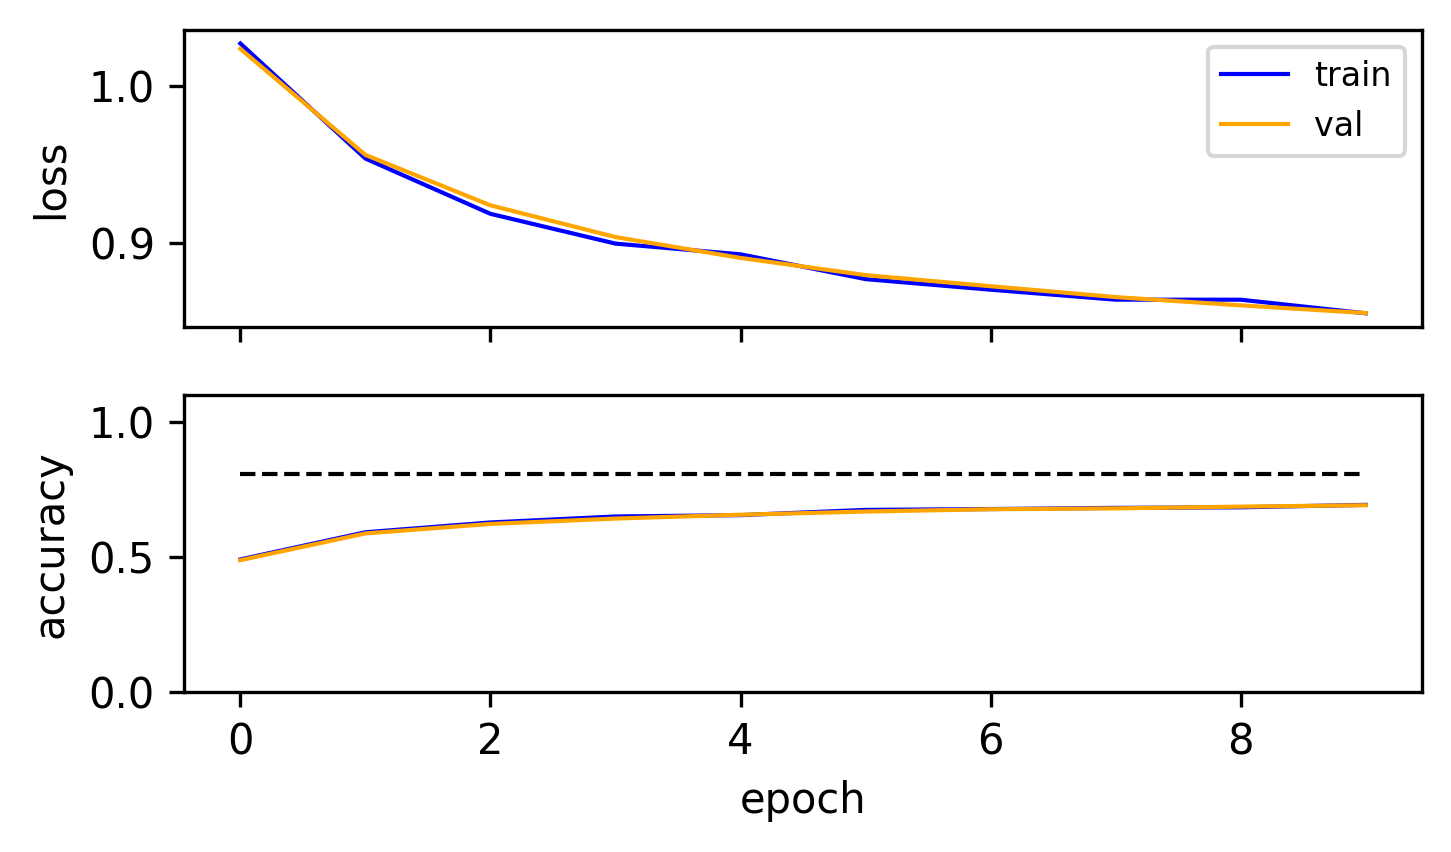

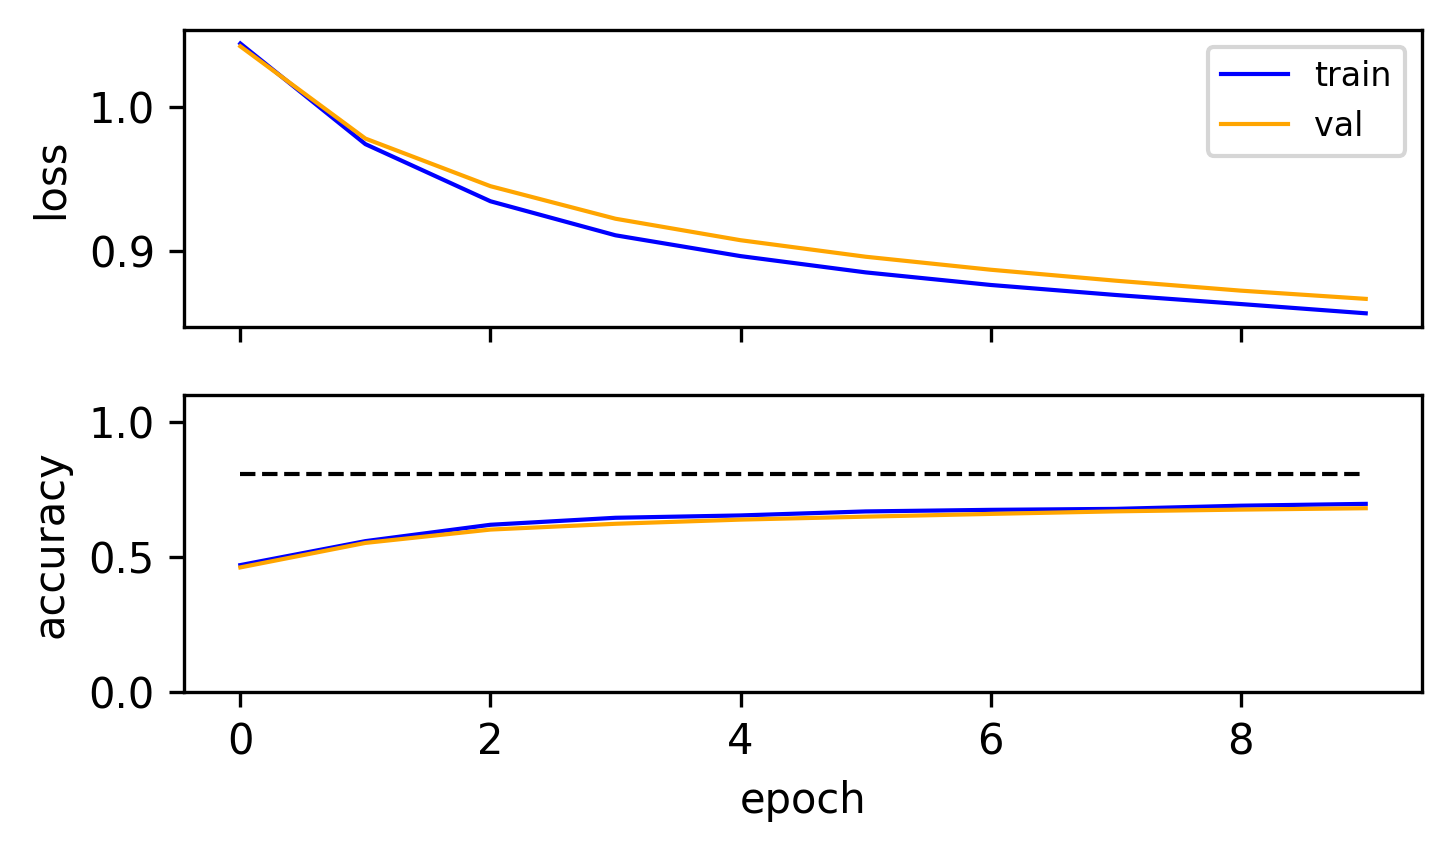

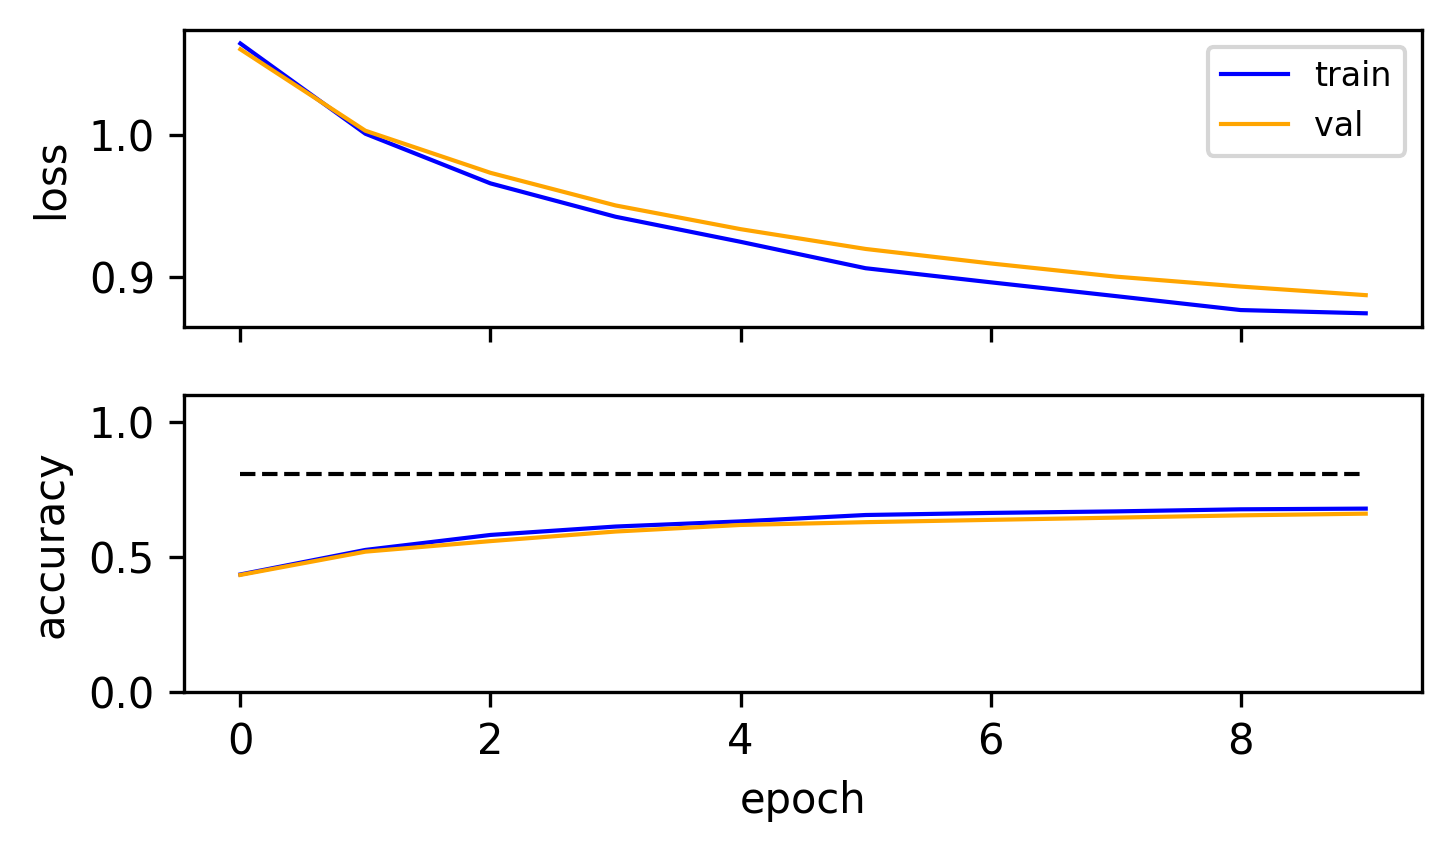

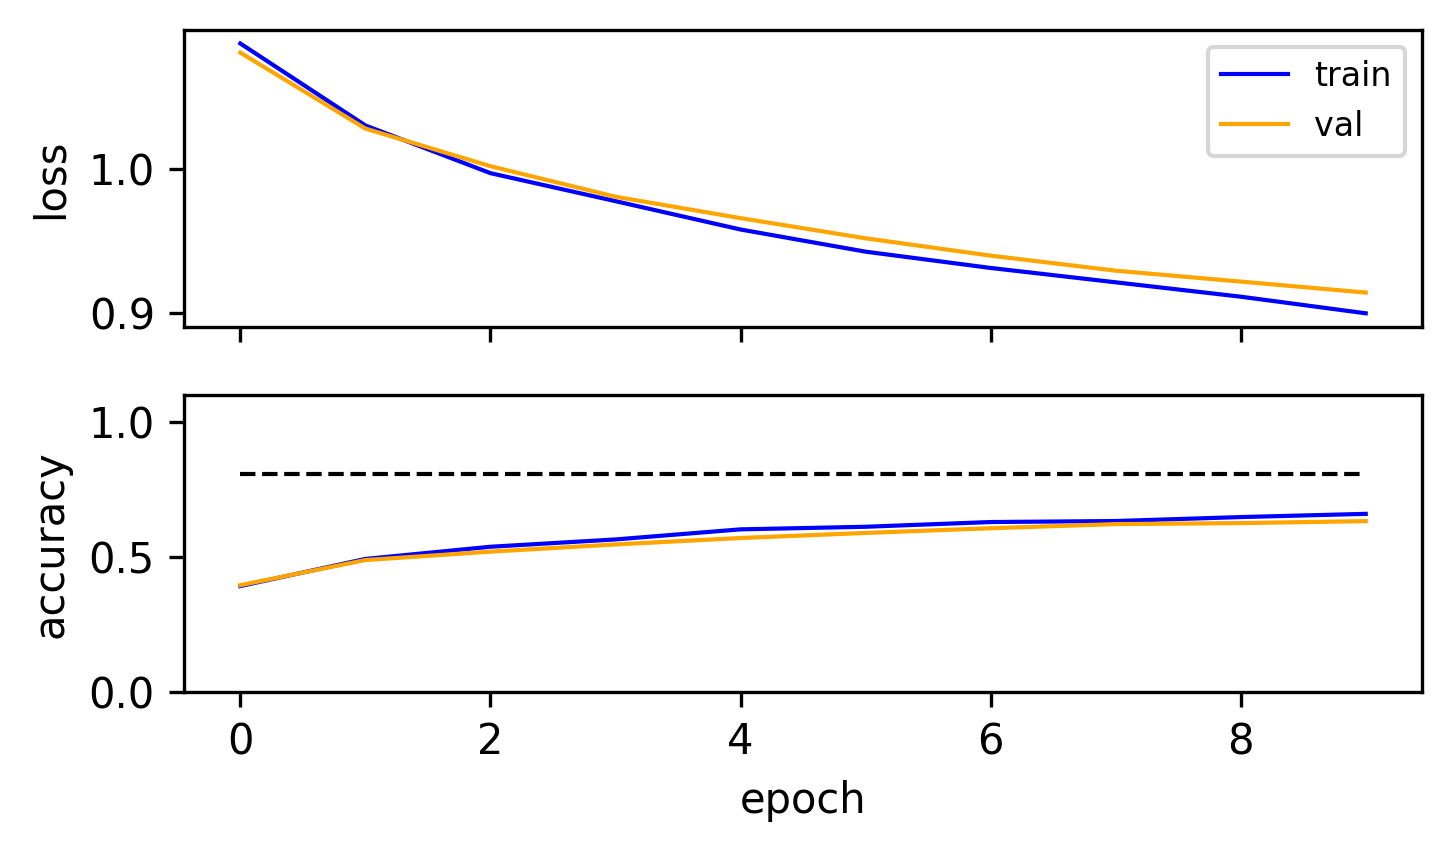

In [94]:
###### STUDENTS ANSWER HERE
import time

hidden_layer_sizes = [256]
batch_sizes = [16, 32, 64, 128, 256]
val_size = 0.2

for batch_size in batch_sizes:
    start_time = time.time()
    results = prep_build_train_eval(X_train, y_train, output_size=output_size, val_size =val_size, baseline=baseline, num_epochs=10, hidden_layer_sizes=hidden_layer_sizes, batch_size=batch_size, random_n=1)
    end_time = time.time()
    print(f"Batch Size: {batch_size}, Training Time: {end_time - start_time} seconds")

In [95]:
####### STUDENTS ANSWER HERE
batch_size = 128 
hidden_layer_sizes_list = [[256], [256, 128], [256, 128, 64], [256, 128, 64, 32], [256, 128, 64, 32, 16]]
val_size = 0.2 


using 10107 (1.00) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
  (drop1): Dropout1d(p=0.1, inplace=False)
  (soft): Softmax(dim=1)
)

model has 34563 trainable parameters

best scores:

  training = 0.68
  validation = 0.66

using 10107 (1.00) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256

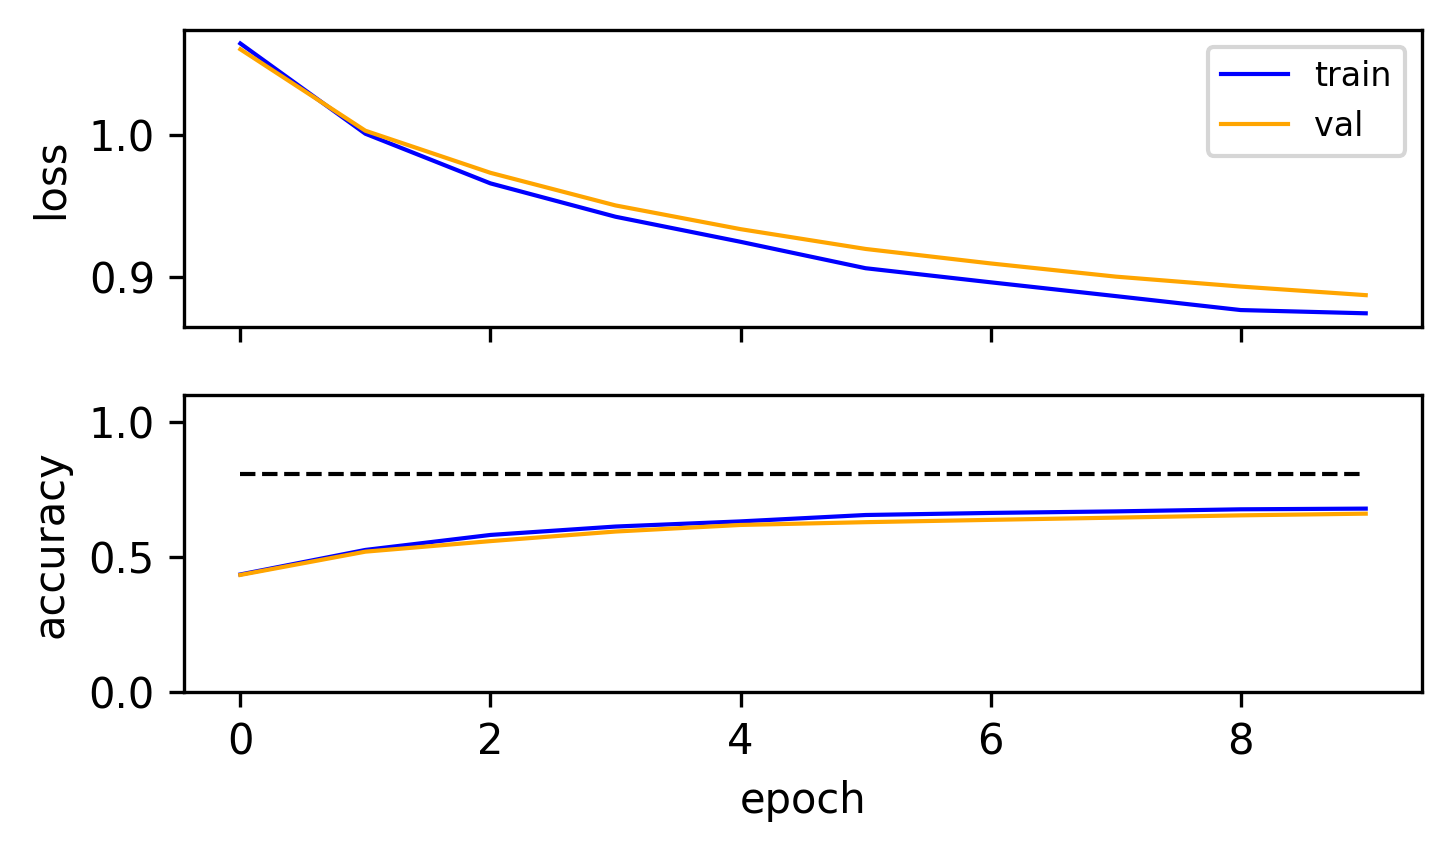

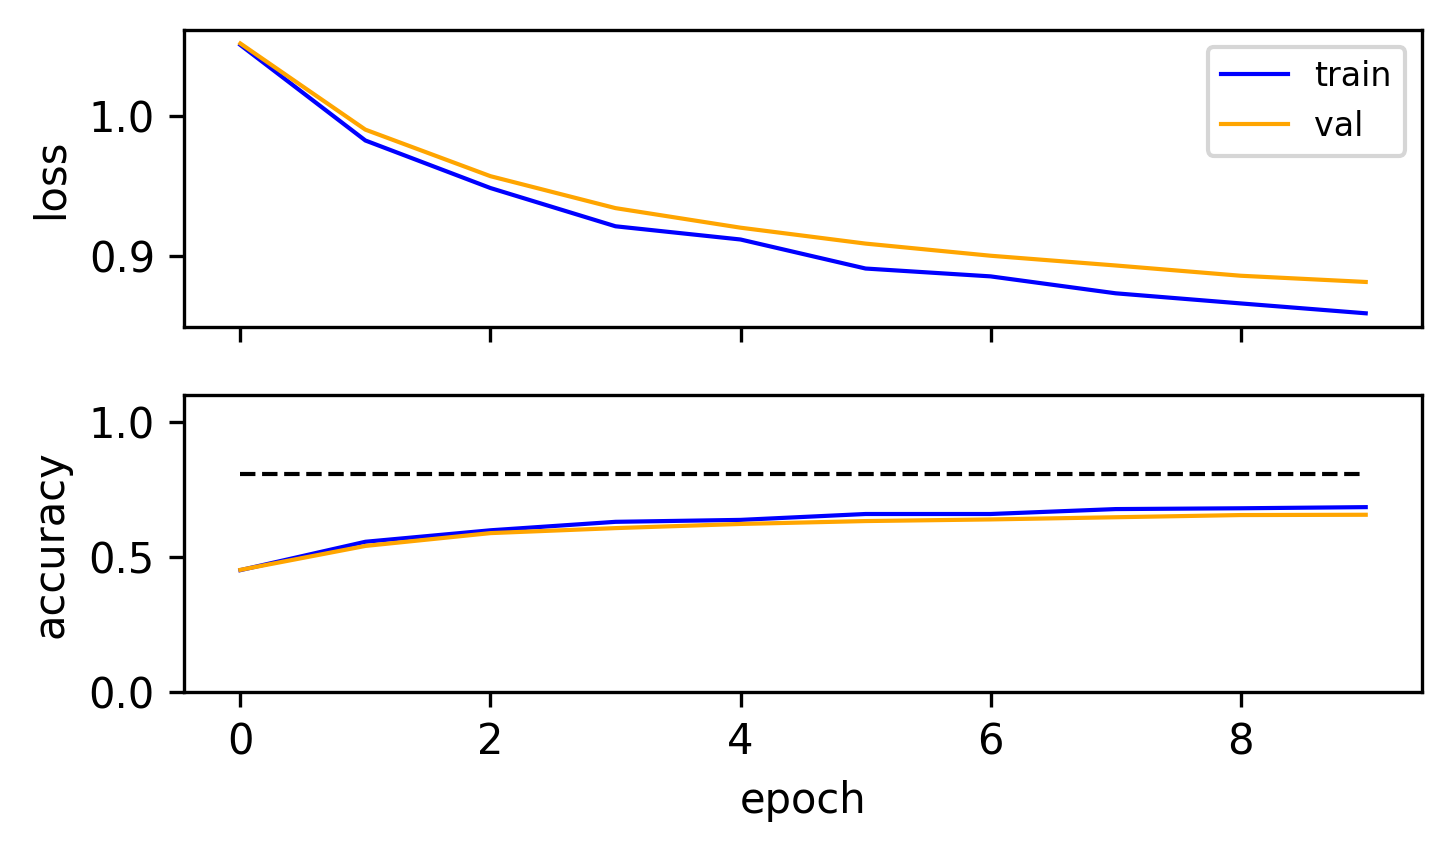

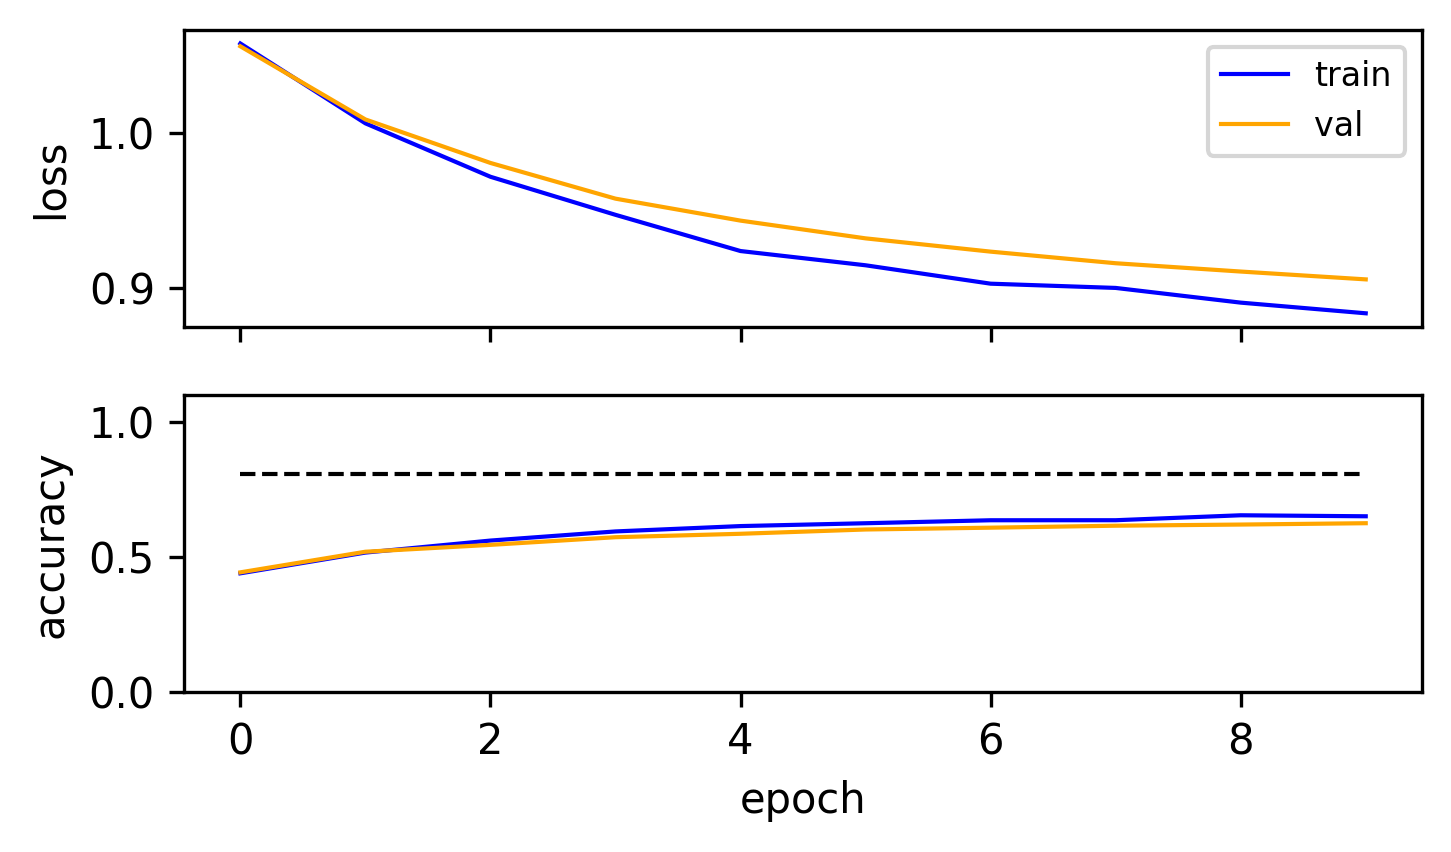

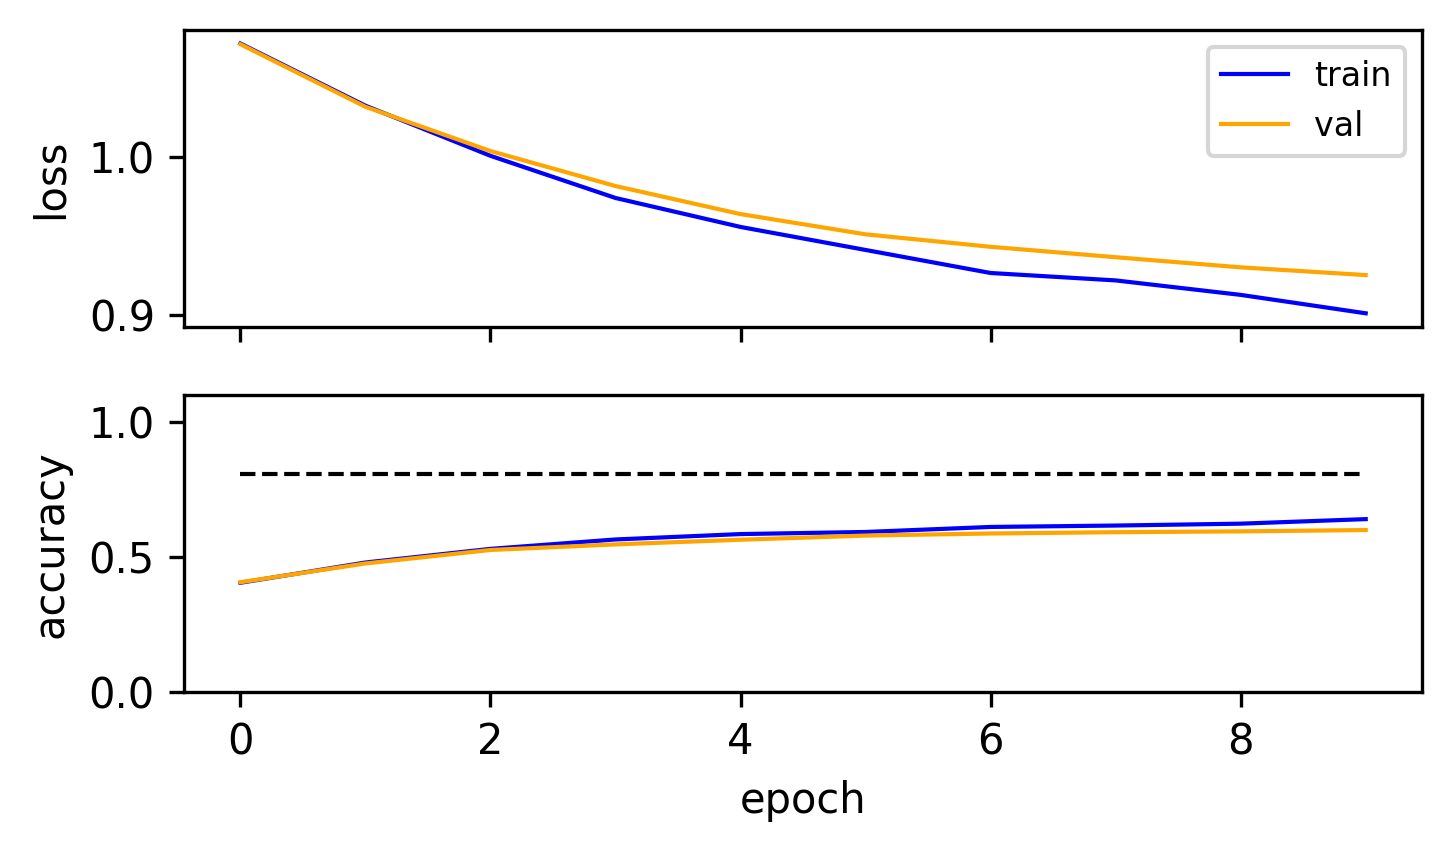

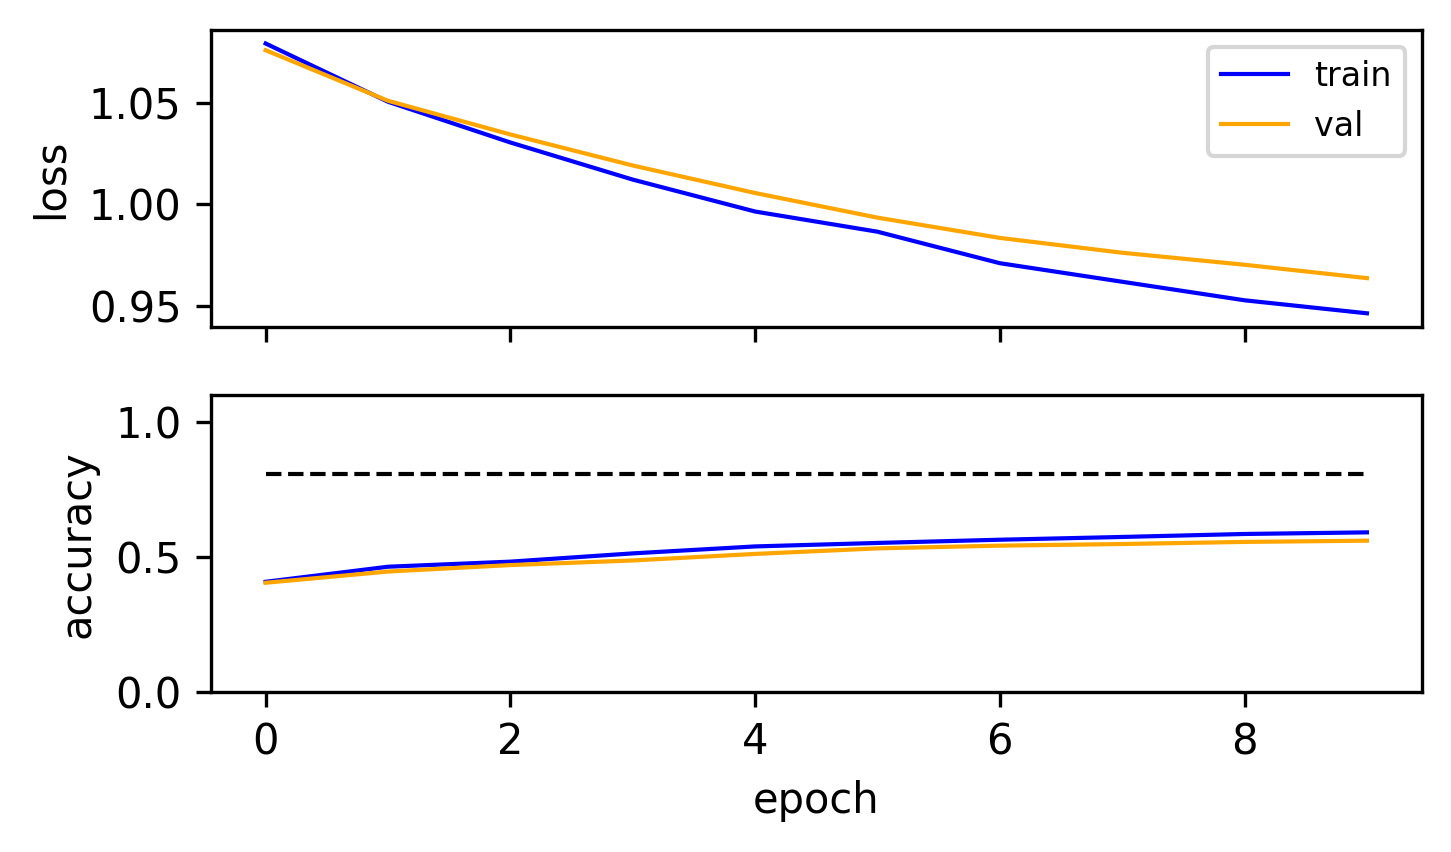

In [100]:
######## STUDENTS ANSWER HERE
for hidden_layer_sizes in hidden_layer_sizes_list:
    start_time = time.time()
    results = prep_build_train_eval(X_train, y_train, output_size=output_size, val_size=val_size, baseline=baseline, num_epochs=10, hidden_layer_sizes=hidden_layer_sizes, batch_size=batch_size, random_n=1)
    end_time = time.time()
print(f"Hidden Layer Sizes: {hidden_layer_sizes}, Training Time: {end_time - start_time} seconds")

## STUDENTS ANSWER HERE

## (3f) Try at least three learning rates
**Guidelines**:
- choose how much data you'd like to use
- choose a batch size that you think is reasonable
- choose a model architecture that you think is reasonable
- turn off all forms of regularization
- train for ~50-1000 epochs, depending on your patience and other decisions you make
- use whatever you would like for `norm`, `dropout`, `act_fn`
- show the results for at least three learning rates
- report one learning rate that is too small, one that is too large, and one that is just right
  - briefly explain how the plots you show align with these labels as too small / too large / just right


using 1010 (0.10) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=3, bias=True)
  (drop1): Dropout1d(p=0.1, inplace=False)
  (soft): Softmax(dim=1)
)

model has 34563 trainable parameters

best scores:

  training = 0.91
  validation = 0.65

using 1010 (0.10) data points
Sequential(
  (norm0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=256, bias=True)
  (act0): LeakyReLU(negative_slope=0.01)
  (drop0): Dropout1d(p=0.1, inplace=False)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, 

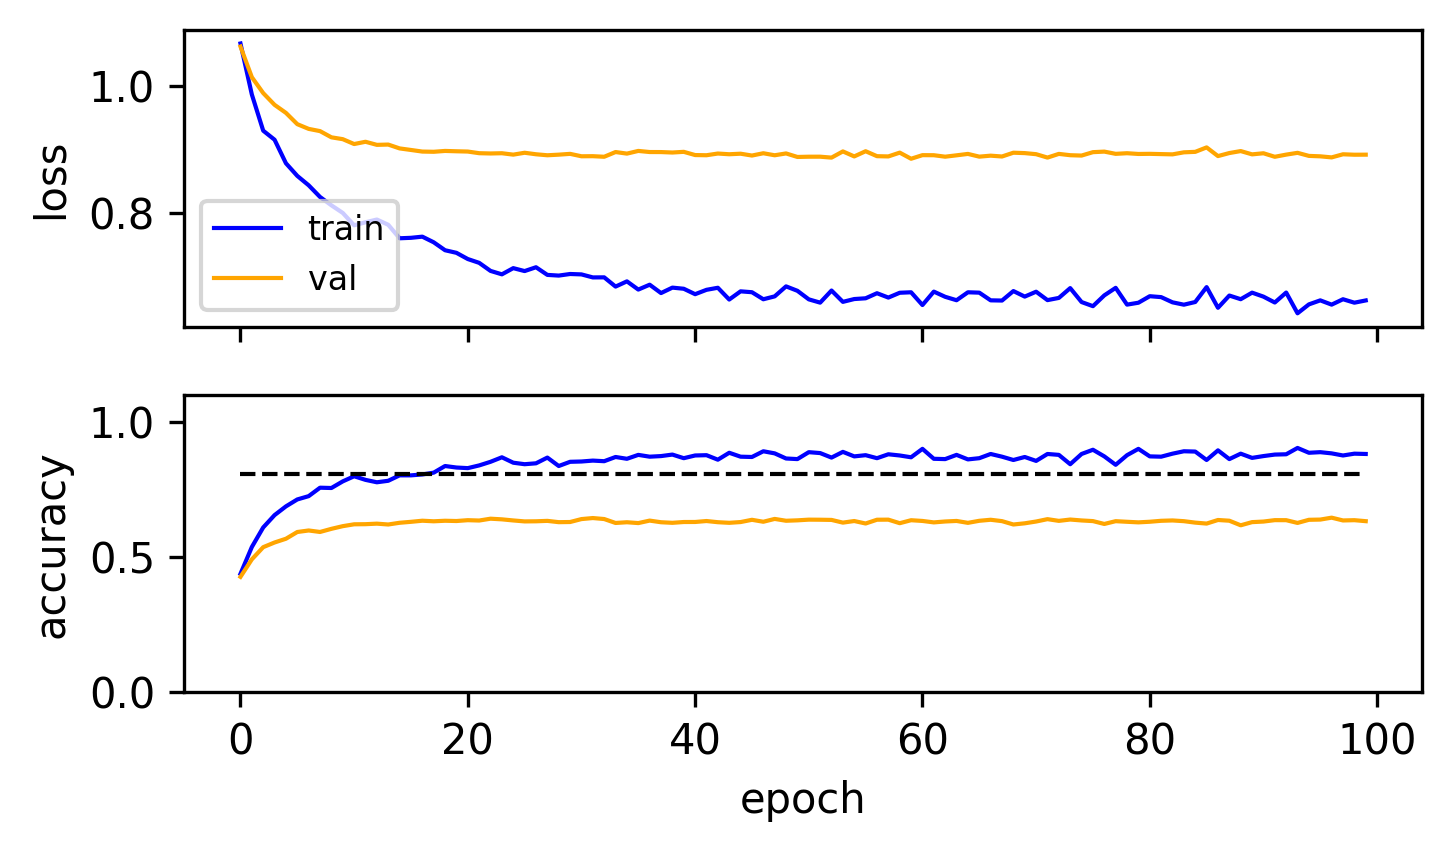

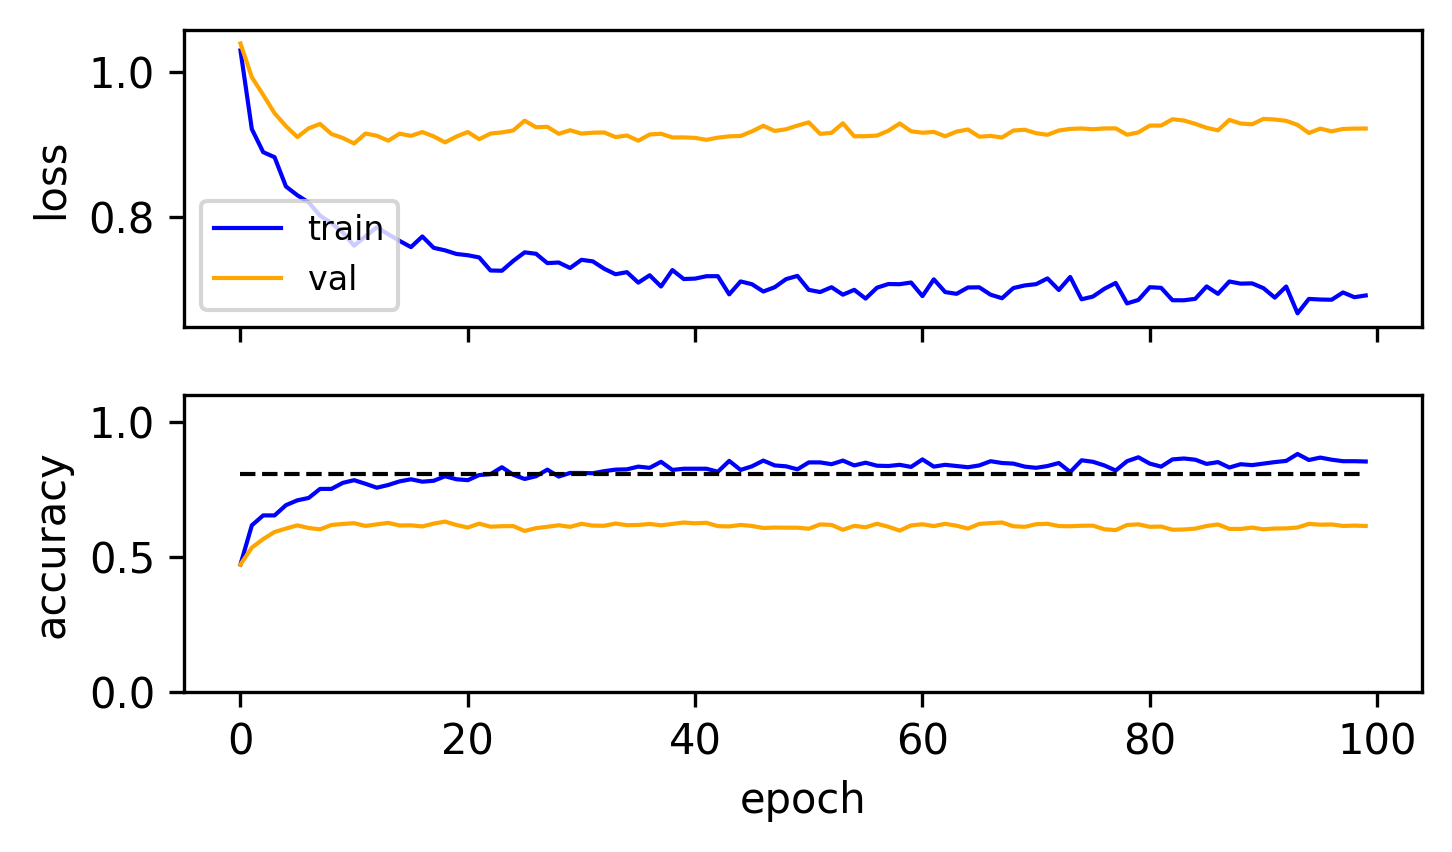

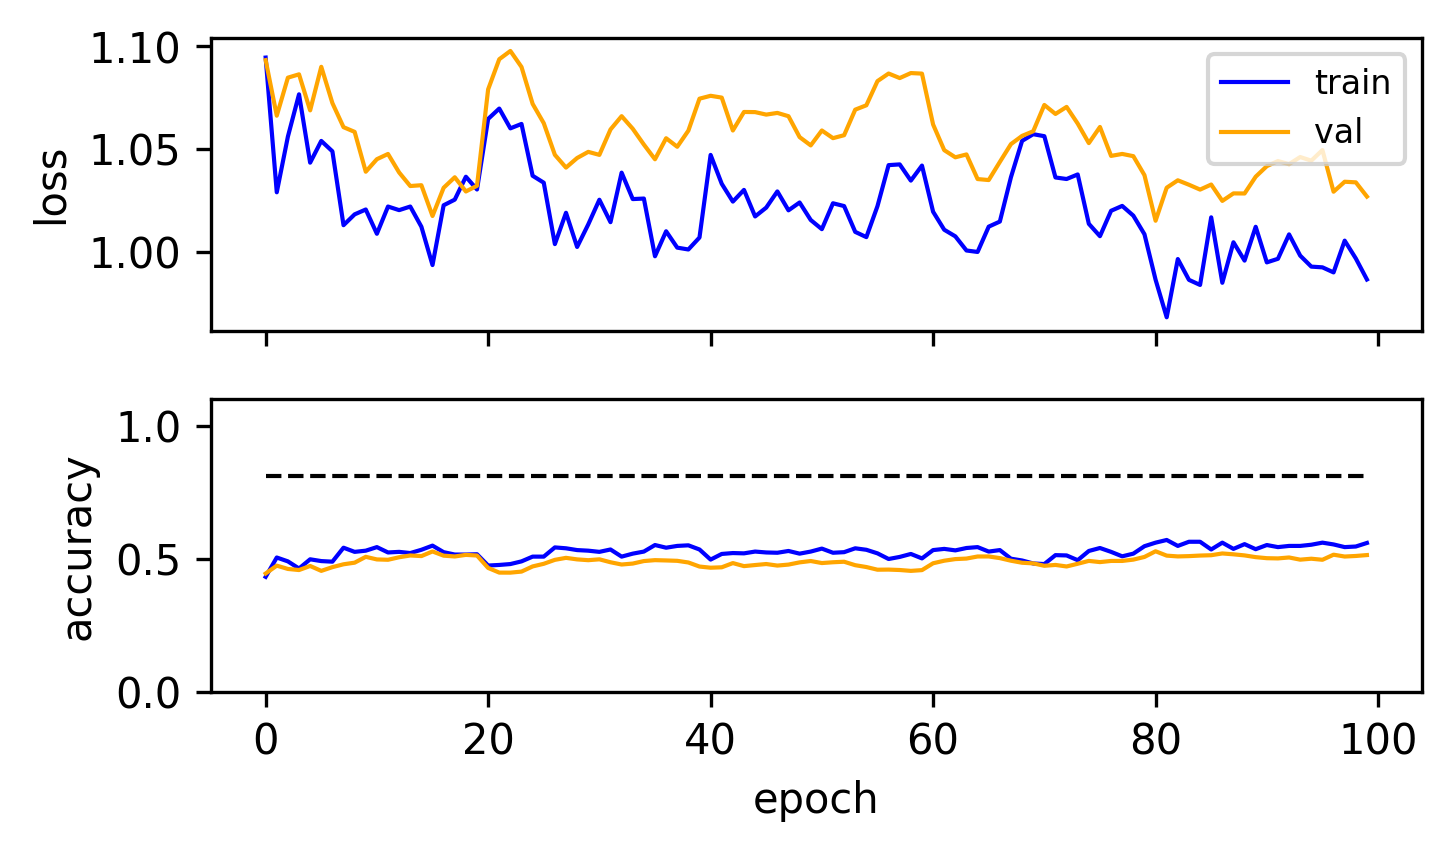

In [107]:
######### STUDENTS ANSWER HERE
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    results = prep_build_train_eval(X_train, y_train, output_size=output_size, baseline=baseline, num_epochs=100, hidden_layer_sizes=[256], learning_rate=lr, batch_size=128, random_n=10)

### STUDENTS ANSWER HERE
Learning rate of 0.001 is too low, 0.01, is reasonable, and 0.1 is too high


- If the learning rate is extremely low, the model may converge very slowly, requiring a large number of epochs to reach a reasonable level of accuracy. In the accuracy plot, a slow, gradual increase in accuracy over many epochs or plateaus later might be observed; in the loss plot, the loss might decrease very slowly and plateau early on.


- If the learning rate is too high, the model updates may be too aggressive, causing it to oscillate or diverge during training. You might see Erratic behavior can be observed in the accuracy plot, with the accuracy jumping around or even decreasing after some epochs. In the loss plot, the loss might oscillate wildly or increase over time.


- A suitable learning rate allows the model to converge efficiently without oscillation or divergence. In the accuracy plot, a steady increase in accuracy over epochs was observed, and in the loss plot, the loss steadily decreased. The model should achieve a high level of accuracy within a reasonable number of epochs.

## (3g) You are probably seeing that your best learning rate is over-fitting to the training data (your training accuracy >> your validation accuracy). Explain how two approaches implemented in `construct_model` can help decrease over-fitting

### STUDENTS ANSWER HERE

1. Dropout randomly sets a fraction of the input units to zero during training, which helps prevent overfitting by reducing the model’s reliance on specific neurons. This regularization technique forces the network to learn more robust features and prevents it from memorizing training data.
2. Weight decay, also known as L2 regularization, adds a penalty term to the loss function, which discourages large weights. This encourages the model to learn simpler patterns and prevents it from fitting noise in the training data. By penalizing large weights, the weight decay effectively reduces the capacity of the model, leading to better generalization performance.


## Recall, we got 82% validation accuracy with a simple Support Vector Classifier!! More is not always better! 
### Deep learning models are best suited when:
- we have very many data points (usually at least ~10k; often need at least ~100k)
- we have very unstructured data (images, spectra, videos, materials, molecules)
- we have GPUs to train them for very many epochs with large networks (hundreds of thousands of paremeters)

### Caveat
- even though it seems like what we did was complex, there are **very** many types of deep learning architectures, so we could probably do quite a bit better even for this problem